<a href="https://colab.research.google.com/github/SYCHOSY/Data-Science/blob/master/4_4_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
keras.__version__

'2.5.0'

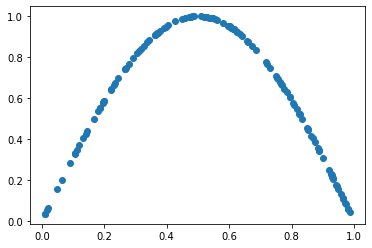

In [2]:
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [0,1]
	X1 = np.random.rand(n)
	# generate outputs sin(1*pi*x1) : 0~180
	X2 = np.sin(X1*np.pi*1)
	# stack arrays
	X1 = X1.reshape(n, 1)		#(n,1)<-(n)
	X2 = X2.reshape(n, 1)		#(n개의 1차원 vector)<-(n차원 vector) 
	X = np.hstack((X1, X2))	#(n,2)<-(n,1)(n,1)
	# generate class labels
	y = np.ones((n, 1))	#True 
	return X, y 				#((n,2),1)

# generate samples
data = generate_real_samples(128)
# plot real samples
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show() #순서가 random인 sin 

In [3]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2): #target이 없음
	model = keras.models.Sequential(name="Discriminator")
	model.add(layers.Dense(25, activation='relu', 
	            kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(layers.Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

d_model=define_discriminator()
d_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [4]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = keras.models.Sequential(name="Generator")
	model.add(layers.Dense(15, activation='relu',
	                       kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(layers.Dense(n_outputs, activation='linear'))
	return model #loss가 없음

g_model=define_generator(5)
g_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator): # target이 없음
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = keras.models.Sequential()
	# add generator
	model.add(generator) 			
	# add the discriminator
	model.add(discriminator) 	#출력이 1이면->CE작어져->Gen학습됨
	# compile model  ## 
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

gan_model=define_gan(g_model,d_model)
gan_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 2)                 122       
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


In [6]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

generate_latent_points(5,2)

array([[ 1.84693514, -0.51427591,  0.12175099,  0.25875287, -0.32611633],
       [ 0.20079121,  0.65187246,  1.59530466,  0.81397546, -0.86656781]])

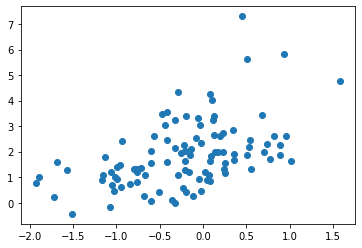

In [7]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)  #(n,2)<-(n,5) 
	# create class labels
	y = np.zeros((n, 1))
	return X, y 				#((n,2),1)
	
# generate and plot fake samples
data = generate_fake_samples(g_model, 5, 100)
# plot fake samples
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show()

Epoch:0   Acc_real:0.000000   Acc_fake:1.000000


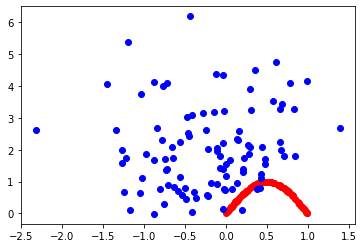

In [8]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, 
                          n=100, ovr=False):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	if ovr: 
		display.clear_output(wait=True)
	print("Epoch:%d   Acc_real:%f   Acc_fake:%f" % (epoch, acc_real, acc_fake))
	# scatter plot real and fake data points
	plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	plt.show()

summarize_performance(0,g_model,d_model,5, ovr=False)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=1024, n_eval=100, over=False):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch) 
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim, ovr=over)